In [9]:
import gym
import numpy as np
import pickle
from tqdm import tqdm
from pathlib import Path
from enum import IntEnum
import matplotlib.pyplot as plt

ALPHA = 0.1
GAMMA = 0.999
TRAIN_COUNT = 100000
TRAIN_STEP_DEBUG = TRAIN_COUNT // 10
TEST_COUNT = 1
EPS = 0.05

MAZE_RESET_INTERVAL = 8

class dir(IntEnum):
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3

movement = [(-1, 0), (1, 0), (0, -1), (0, 1)]

class MazeEnv():
    '''
        state: (up, down, left, right), 4^5
    '''
    def __init__(self, maze_file_list: list, test_flag: bool = False):
        # super(MazeEnv, self).__init__()
        self.test_flag = test_flag
        self.maze_cnt = len(maze_file_list)
        self.maze_idx = 0
        self.reset_cnt = 0
        self.maze_info_list = [] # list of tuple (maze file name, visit count, passable)

        for maze_file in maze_file_list:
            with open(maze_file) as mf:
                lines = mf.readlines()
            
            N = len(lines) // 2
            start_position = (0, 0)
            end_position = (N - 1, N - 1)
            passable = np.zeros(shape=(N, N, 4), dtype=bool)
                    
            for (x, y) in np.ndindex((N, N)):
                mf_x = x * 2 + 1
                mf_y = y * 2 + 1

                if lines[mf_x - 1][mf_y] == ' ':
                    passable[x][y][dir.UP] = True

                if lines[mf_x + 1][mf_y] == ' ':
                    passable[x][y][dir.DOWN] = True

                if lines[mf_x][mf_y - 1] == ' ':
                    passable[x][y][dir.LEFT] = True

                if lines[mf_x][mf_y + 1] == ' ':
                    passable[x][y][dir.RIGHT] = True
            
            maze_info = {
                'maze_file': maze_file,
                'N': N,
                'move_limit': 100 * N * N,
                'start_position': start_position,
                'end_position': end_position,
                'passable': passable
            }

            self.maze_info_list.append(maze_info)

        self._load_maze(0, False)
        return

        
    def _load_maze(self, i: int, reverse: bool):
        maze_info = self.maze_info_list[i]
        self.maze_file = maze_info['maze_file']
        self.N = maze_info['N']
        self.move_limit = maze_info['move_limit']
        self.start_position = maze_info['start_position']
        self.end_position = maze_info['end_position']
        self.passable = maze_info['passable']
        if reverse == True:
            self.start_position, self.end_position = self.end_position, self.start_position
            
        self.position = self.start_position
        self.visit_count = np.zeros((self.N, self.N), dtype=np.int32)
        self.visit_count[self.position] = 1
        return


    def _get_state(self) -> tuple:
        state_vector = [0] * 4 # up down left right
        for action in range(4):
            if self.passable[self.position][action]:
                next_position = (self.position[0] + movement[action][0], self.position[1] + movement[action][1])
                if self.visit_count[next_position] == 0:
                    state_vector[action] = 0
                elif self.visit_count[next_position] <= 2:
                    state_vector[action] = 1
                else:
                    state_vector[action] = 2
            else:
                state_vector[action] = 3

        return tuple(state_vector) 


    def get_available_actions(self):
        available_actions = np.argwhere(self.passable[self.position])
        return available_actions


    def step(self, action: dir):
        '''
            returns: next_state, reward, done
        '''
        # assert self.passable[self.position][action] == True

        done = False        
        self.position = (self.position[0] + movement[action][0], self.position[1] + movement[action][1])
        self.visit_count[self.position] += 1
        if self.position == self.end_position:
            done = True
            reward = 5
        elif self.visit_count[self.position] > 3: # visited 3 times -> penalty 
            reward = -1
        else:
            reward = 0.2
        
        state = self._get_state()
        return state, reward, done


    def reset(self) -> tuple:
        '''
        return: state, move_limit
        '''
        # (self.reset_cnt < MAZE_RESET_INTERVAL) or
        if self.reset_cnt % MAZE_RESET_INTERVAL == 0:
            self.maze_idx = (self.maze_idx + 1) % self.maze_cnt
            reverse = (not self.test_flag) and (np.random.random() < 0.5)
            self._load_maze(self.maze_idx, reverse)

        self.reset_cnt += 1
        state = self._get_state()
        return state, self.move_limit




In [10]:

class Agent:
    def __init__(self, env, q_val = None):
        self.env = env

        if q_val is None:
            self.q_val = np.random.randn(4, 4, 4, 4, 4)
            # self.q_val[(3,3,3,3)] = 0
            # self.q_val = np.zeros(shape=(4, 4, 4, 4, 4), dtype=float)
        else:
            print('using q value from another agent')
            self.q_val = q_val


    def train_qlearning(self):
        state, move_limit = self.env.reset()
        
        for t in range(move_limit):
            available_actions = self.env.get_available_actions()
            if np.random.rand() < EPS:
                action = available_actions[np.random.randint(len(available_actions))]
            else:
                action = available_actions[np.argmax(self.q_val[state].take(available_actions))]
            
            action = action[0]
            next_state, reward, done = self.env.step(action)
            q_next_max = np.max(self.q_val[next_state])
            self.q_val[state][action] += ALPHA * (reward + GAMMA * q_next_max - self.q_val[state][action])
            
            if done:
                return reward
            else:
                state = next_state

        return 0.0

    def train_sarsa(self):
        state, move_limit = self.env.reset()
        if np.random.rand() < EPS:
            action = self.env.action_space.sample() # exploration
        else:
            action = np.argmax(self.q_val[state]) # exploitation
        for t in range(move_limit):
            next_state, reward, done = self.env.step(action)

            if np.random.rand() < EPS:
                new_action = self.env.action_space.sample() # exploration
            else:
                new_action = np.argmax(self.q_val[state]) # exploitation
            self.q_val[state][action] += ALPHA * (reward + GAMMA * self.q_val[next_state][new_action] - self.q_val[state][action])

            if done:
                return reward

            state = next_state
            action = new_action
            
        return 0.0



    def test(self):
        state, move_limit = self.env.reset()
        for t in range(move_limit):
            available_actions = self.env.get_available_actions()
            action = available_actions[np.argmax(self.q_val[state].take(available_actions))]
            action = action[0]
            next_state, reward, done = self.env.step(action)
            if done:
                return reward
            else:
                state = next_state

        return 0.0

In [11]:
agent_dict = {} # (maz_file_list, agent)

 10%|█         | 10002/100000 [07:05<2:03:44, 12.12it/s]

train_step: 10000 / 100000 : average_reward=3.205


 20%|██        | 20021/100000 [13:33<57:03, 23.36it/s]  

train_step: 20000 / 100000 : average_reward=3.230


 30%|███       | 30005/100000 [20:08<1:10:13, 16.61it/s]

train_step: 30000 / 100000 : average_reward=3.229


 40%|████      | 40017/100000 [27:01<51:37, 19.36it/s]  

train_step: 40000 / 100000 : average_reward=3.215


 50%|█████     | 50022/100000 [33:37<21:55, 38.00it/s]  

train_step: 50000 / 100000 : average_reward=3.220


 60%|██████    | 60011/100000 [40:33<07:36, 87.62it/s]  

train_step: 60000 / 100000 : average_reward=3.207


 70%|███████   | 70006/100000 [48:01<27:24, 18.24it/s]  

train_step: 70000 / 100000 : average_reward=3.195


 80%|████████  | 80026/100000 [55:16<10:47, 30.87it/s] 

train_step: 80000 / 100000 : average_reward=3.186


 90%|█████████ | 90004/100000 [1:02:12<04:30, 36.89it/s]

train_step: 90000 / 100000 : average_reward=3.180


100%|██████████| 100000/100000 [1:08:59<00:00, 24.16it/s]


train_step: 100000 / 100000 : average_reward=3.181


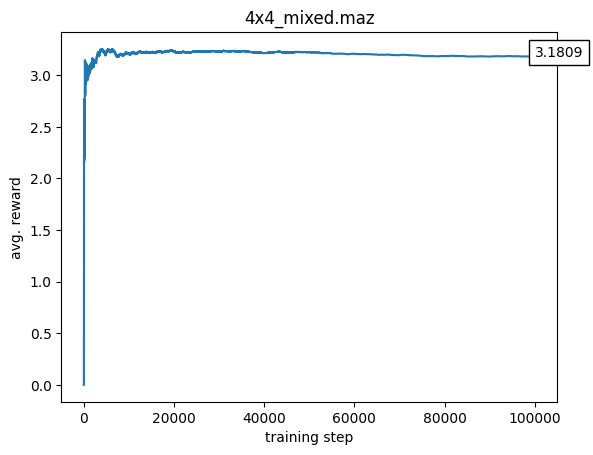

In [12]:
# maze_file_train_list = ['4x4_1.maz']
# '2x2_1.maz', '2x2_2.maz', '2x2_3.maz', '2x2_4.maz', 


maze_file_train_list = [
    '4x4_1.maz', 
    '4x4_2.maz', 
    '4x4_3.maz', 
    '4x4_4.maz', 
    '4x4_5.maz', 
    '4x4_6.maz', 
    '4x4_7.maz', 
    '4x4_8.maz',
    '6x6_1.maz',
    '6x6_2.maz',
    '6x6_3.maz',
    '6x6_4.maz',
    '3x3_1.maz',
    '3x3_2.maz',
    '3x3_3.maz',
    '3x3_4.maz',
    '3x3_5.maz',
    '3x3_6.maz',
    '3x3_7.maz',
    '10x10_1.maz'
    ]

train_env = MazeEnv(maze_file_train_list)

train_agent = Agent(train_env)

train_reward_total = 0.0
average_reward_list = []

for train_step in tqdm(range(TRAIN_COUNT)):
    train_reward_total += train_agent.train_qlearning()
    average_reward = train_reward_total / (train_step + 1)
    average_reward_list.append(average_reward)
    if (train_step + 1) % TRAIN_STEP_DEBUG == 0:
       print(f'train_step: {(train_step+1):05d} / {TRAIN_COUNT} : {average_reward=:.3f}')
    
average_reward_list = np.array(average_reward_list)
plt.plot(average_reward_list)
plt.ylabel('avg. reward')
# plt.ylim(0,1)
plt.xlabel('training step')
plt.text(TRAIN_COUNT-1, average_reward_list[-1], average_reward_list[-1], ha='left', bbox=dict(facecolor='white', alpha=1.0))
plt.title('4x4_mixed.maz')
plt.show()

agent_dict['train_1'] = (maze_file_train_list, train_agent, average_reward_list)


In [13]:
print(train_agent.q_val)

[[[[[ 8.47448146e-01 -9.17420880e-01  9.97077132e-01  2.33355441e-01]
    [ 1.62679344e+00  1.83380689e+00  9.95120981e-01  7.35303258e+00]
    [ 5.63652337e+00  6.45129310e-01  1.78031198e+00  8.81616530e-02]
    [-4.07446349e-02 -1.01250457e+00  1.82447448e+00 -1.26896449e+00]]

   [[-8.64052714e-01 -2.67989441e-01  2.06560110e+00 -6.91382879e-01]
    [-9.00018279e-01 -2.34724980e+00 -1.32893344e+00  2.13950190e+00]
    [ 8.69558594e-01 -5.91315880e-01 -9.79316214e-01 -1.35574330e+00]
    [ 6.21530707e+00  6.96974045e+00  6.78719483e+00  5.26077118e-02]]

   [[ 5.56609723e-01  1.10517348e+00 -5.36712367e-01  7.68908845e-01]
    [-1.67365031e+00  1.46615199e+00 -5.47303430e-01  1.34828970e-01]
    [-4.84000731e-01  1.06881674e+00  2.49525024e-02  3.28619981e-01]
    [ 5.99752738e+00  5.23457998e+00  6.61373074e-01  3.04545763e-01]]

   [[-1.62713576e+00 -1.34611289e+00  3.16959062e-01  1.76576991e+00]
    [ 8.90505913e+00  6.68937049e+00 -1.06682596e+00  6.59001157e+00]
    [ 7.533062

In [14]:
# maze_file_train_list = ['4x4_1.maz']
# '2x2_1.maz', '2x2_2.maz', '2x2_3.maz', '2x2_4.maz', 


# maze_file_train_list = ['5x5_1.maz', '5x5_2.maz', '4x4_1.maz', '4x4_2.maz', '4x4_3.maz', '4x4_4.maz', '4x4_5.maz', '4x4_6.maz', '4x4_7.maz', '6x6_1.maz', '6x6_2.maz', '6x6_3.maz', '6x6_4.maz']

# train_env = MazeEnv(maze_file_train_list)

# train_agent = Agent(train_env)

# train_reward_total = 0.0
# average_reward_list = []

# for train_step in tqdm(range(TRAIN_COUNT)):
#     train_reward_total += train_agent.train()
#     average_reward = train_reward_total / (train_step + 1)
#     average_reward_list.append(average_reward)
#     if (train_step + 1) % TRAIN_STEP_DEBUG == 0:
#        print(f'train_step: {(train_step+1):05d} / {TRAIN_COUNT} : {average_reward=:.3f}')
    
# average_reward_list = np.array(average_reward_list)
# plt.plot(average_reward_list)
# plt.ylabel('avg. reward')
# plt.ylim(0,10)
# plt.xlabel('training step')
# plt.text(TRAIN_COUNT-1, average_reward_list[-1], average_reward_list[-1], ha='left', bbox=dict(facecolor='white', alpha=1.0))
# plt.title('4x4_mixed.maz')
# plt.show()

# agent_dict['train_5'] = (maze_file_train_list, train_agent, average_reward_list)


In [15]:
print(train_agent.q_val[3][3][3][0])

[-0.4729642  -2.2792189   0.50290434  7.53202246]


In [18]:
maze_file_test_list = ['10x10_3.maz']
test_env = MazeEnv(maze_file_test_list, True)
test_agent = Agent(test_env, train_agent.q_val)
test_reward_total = 0
for test_step in tqdm(range(1)):
    test_reward_total += test_agent.test()
test_average_reward = test_reward_total / TEST_COUNT
print(f'{test_average_reward=}')

using q value from another agent


100%|██████████| 1/1 [00:00<00:00, 422.13it/s]

test_average_reward=5.0


In [17]:
import platform
print(platform.python_implementation())

CPython
